In [1]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from tensorflow.keras import Model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage import io, transform
from skimage.io import imread
from tensorflow.keras.models import load_model
import numpy as np
import cv2
from sklearn.metrics import label_ranking_average_precision_score
import time
%matplotlib inline


In [ ]:
PATH = 
img = imread()

train, test = train_test_split(df, test_size=0.2)

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [4]:
def train_model():
    input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    autoencoder.fit(x_train_noisy, x_train,
                    epochs=20,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test),
                    callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

    autoencoder.save('autoencoder.h5')

train_model()

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 62s 1ms/step - loss: 0.2406 - val_loss: 0.1981
Epoch 2/20
60000/60000 [==============================] - 60s 1ms/step - loss: 0.1784 - val_loss: 0.1639
Epoch 3/20
60000/60000 [==============================] - 60s 999us/step - loss: 0.1627 - val_loss: 0.1558
Epoch 4/20
60000/60000 [==============================] - 60s 1ms/step - loss: 0.1548 - val_loss: 0.1534
Epoch 5/20
60000/60000 [==============================] - 60s 992us/step - loss: 0.1497 - val_loss: 0.1450
Epoch 6/20
60000/60000 [==============================] - 59s 989us/step - loss: 0.1460 - val_loss: 0.1412
Epoch 7/20
60000/60000 [==============================] - 59s 986us/step - loss: 0.1432 - val_loss: 0.1419
Epoch 8/20
60000/60000 [==============================] - 59s 990us/step - loss: 0.1410 - val_loss: 0.1481
Epoch 9/20
60000/60000 [==============================] - 60s 993us/step - loss: 0.1388 - val_loss: 

In [40]:
print('Loading mnist dataset')
t0 = time.time()
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
t1 = time.time()
print('mnist dataset loaded in: ', t1-t0)

print('Loading model :')
t0 = time.time()
# Load previously trained autoencoder
autoencoder = load_model('autoencoder.h5')
t1 = time.time()
print('Model loaded in: ', t1-t0)

Loading mnist dataset
('mnist dataset loaded in: ', 3.654482841491699)
Loading model :
('Model loaded in: ', 3.463449001312256)


In [41]:
def plot_denoised_images():
    denoised_images = autoencoder.predict(x_test_noisy.reshape(x_test_noisy.shape[0], x_test_noisy.shape[1], x_test_noisy.shape[2],1))
    test_img = x_test_noisy[0]
   # plt.figure(figsize=(4,2))
    plt.figure(figsize=(20,5))
    plt.subplot(311)
    plt.imshow(test_img.reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    #resized_test_img = cv2.resize(test_img, (280, 280))
    #cv2.imshow('input', resized_test_img)
    #cv2.waitKey(0)
    output = denoised_images[0]
    #plt.figure(figsize=(4,2))
    R= test_img[0]-denoised_images[0] 
    plt.subplot(312)
    plt.imshow( output.reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    
    plt.subplot(313)
    plt.imshow( R.reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    
    #resized_output = cv2.resize(output, (280, 280))
    #cv2.imshow('output', resized_output)
    #cv2.waitKey(0)

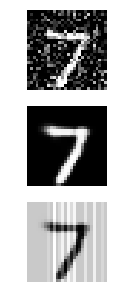

In [42]:
plot_denoised_images()